In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
image_classification_task_list = [
 'Birdsnap',
 'Caltech101',
 'CIFAR10',
 'CIFAR100',
 'Country211',
 'DTD',
 'EuroSAT',
 'FER2013',
 'FGVCAircraft',
 'Food101Classification',
 'GTSRB',
 'Imagenet1k',
 'MNIST',
 'OxfordFlowersClassification',
 'OxfordPets',
 'PatchCamelyon',
 'RESISC45',
 'StanfordCars',
 'STL10',
 'SUN397',
 'UCF101']
finegrained_tasks = [
 'Birdsnap',
 'Caltech101',
 'CIFAR100',
 'Country211',
 'FGVCAircraft',
 'Food101Classification',
 'Imagenet1k',
 'OxfordFlowersClassification',
 'OxfordPets',
 'RESISC45',
 'StanfordCars',
 'SUN397',
 'UCF101']

coarsegrained_tasks = [x for x in image_classification_task_list if x not in finegrained_tasks]

image_classification_task_list = [x+".json" for x in image_classification_task_list]
finegrained_tasks = [x+".json" for x in finegrained_tasks]
coarsegrained_tasks = [x+".json" for x in coarsegrained_tasks]

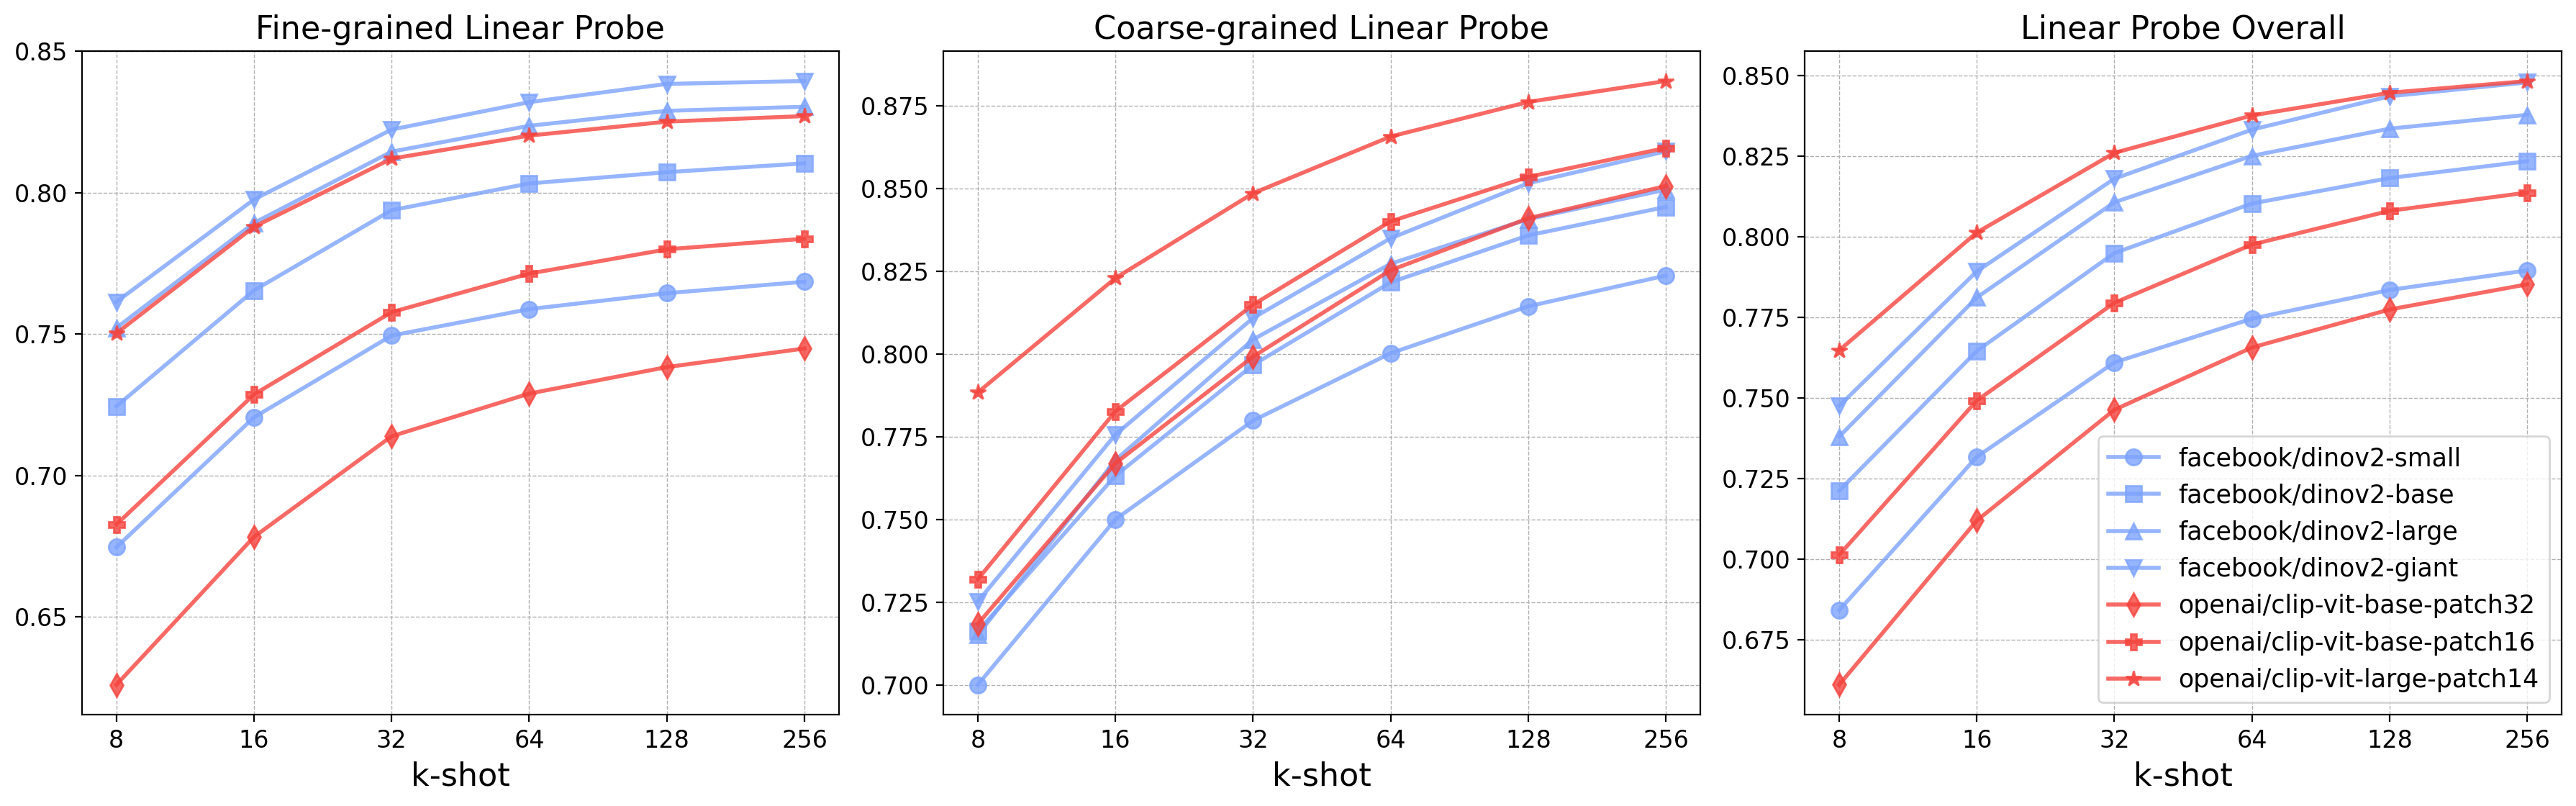

In [3]:
all_results = {}
tasks_types = ["finegrained_tasks", "coarsegrained_tasks", "tasks"]
k_values = [8, 16, 32, 64, 128, 256]

for task_type in tasks_types:
    all_results[task_type] = {}
    for model in ["facebook__dinov2-small", "facebook__dinov2-base", "facebook__dinov2-large",
                  "facebook__dinov2-giant", "openai__clip-vit-base-patch32",
                  "openai__clip-vit-base-patch16", "openai__clip-vit-large-patch14"]:

        for k in k_values:
            directory_path = f"tmp/linear_probe_{k}"
            version = os.listdir(os.path.join(directory_path, model))[0]
            tasks = os.listdir(os.path.join(directory_path, model, version))
            tasks.remove("model_meta.json")
            assert len(tasks) == 21
            extracted_results = []
            for name in eval(task_type):
                with open(os.path.join(directory_path, model, version, name), "r") as file:
                    results = json.load(file)
                    if "test" in results["scores"]:
                        test_results = results["scores"]["test"]
                    else:
                        test_results = results["scores"]["validation"]
                    extracted_result = test_results[0]["accuracy"]
                extracted_results.append(extracted_result)
            
            if model in all_results[task_type]:    
                all_results[task_type][model].append(np.mean(extracted_results))
            else:
                all_results[task_type][model] = [np.mean(extracted_results)]

# Define plot settings
colors = {
    "dinov2": "#7DA3FD",  # Color for dinov2 models
    "clip": "#F5433D"     # Color for clip models
}
markers = ["o", "s", "^", "v", "d", "P", "*"]

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200)#, sharey=True)
# fig.suptitle("Linear Probing Performance across k-shot per Label for Different Task Types", fontsize=16)
task_titles = ["Fine-grained Linear Probe", "Coarse-grained Linear Probe", "Linear Probe Overall"]

# Loop over each task type to plot
for idx, (task_type, ax) in enumerate(zip(tasks_types, axes)):
    df = pd.DataFrame.from_dict(all_results[task_type], orient='index')
    df.columns = map(str, k_values)
    
    for i, model in enumerate(df.index):
        color = colors["dinov2"] if "dinov2" in model else colors["clip"]
        marker = markers[i % len(markers)]
        ax.plot(df.columns, df.loc[model], label=model.replace("__", "/"), color=color, marker=marker, 
                markersize=8, linestyle="-", linewidth=2, alpha=0.8)
    
    ax.set_title(task_titles[idx], fontsize=16)
    ax.set_xlabel("k-shot", fontsize=16)
    ax.set_xticks(range(len(k_values)))
    ax.set_xticklabels(df.columns)
    ax.grid(True, linestyle="--", linewidth=0.5)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
handles, labels = axes[-1].get_legend_handles_labels()
axes[-1].legend(handles, labels, loc="lower right", fontsize=12.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
# plt.savefig("k-shot.pdf")